# Multivariate Multi-step Forecasting: LSTM TF2 - EXPERIMENT

In [43]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [3]:
# Get number of available GPUs-
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"number of GPUs available = {num_gpus}")

number of GPUs available = 0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

No GPU found


In [5]:
path_to_files = "D:/Deep_Learning_resources/Sequence_Modelling_resources/Datasets/Household_Power_Consumption-files/"

In [6]:
# Read in day-wise aggregated and processed data-
data = pd.read_csv(path_to_files + "household_power_consumption_cleaned-days_grouping.csv")

In [7]:
data.shape

(1442, 9)

In [8]:
data.columns

Index(['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'sub_metering_4'],
      dtype='object')

In [9]:
data.dtypes

datetime                  object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
sub_metering_4           float64
dtype: object

In [10]:
data.isna().values.any()

False

In [11]:
# Convert to 'datetime64' format-
data['datetime'] = pd.to_datetime(data['datetime'])

In [12]:
# Sort in ascending order-
data.sort_values(by = 'datetime', inplace = True)

In [13]:
# Drop index-
data.reset_index(drop = True, inplace = True)

In [14]:
# Get min and max date times-
data['datetime'].min(), data['datetime'].max()

(Timestamp('2006-12-16 00:00:00'), Timestamp('2010-11-26 00:00:00'))

In [15]:
# Sanity check-
data.dtypes

datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
sub_metering_4                  float64
dtype: object

In [16]:
data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934
1,2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2,2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
3,2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
4,2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800


### Problem Framing

There are many ways to harness and explore the household power consumption dataset.

In this tutorial, we will use the data to explore a very specific question: __Given recent power consumption, what is the expected power consumption for the week ahead?__

- This __requires a predictive model to forecast the total active power for each day over the next 7 days__, or, __Predict the total active power for each day for the next 7 days__.

- Technically, this framing of the problem is referred to as a __multi-step__ time series forecasting problem, given the multiple forecast steps. __A model that makes use of multiple input variables may be referred to as a _multivariate multi-step_ time series forecasting model__.

A model of this type could be helpful within the household in planning expenditures. It could also be helpful on the supply side for planning electricity demand for a specific household.

This framing of the dataset also suggests that it would be useful to downsample the per-minute observations of power consumption to daily totals. This is not required, but makes sense, given that we are interested in total power per day problem formulation.

We can achieve this with ```resample()``` function on the pandas DataFrame. Calling this function with the argument 'D' allows the loaded data indexed by date-time to be grouped by day. See all [offset aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html).

We can then calculate the sum of all observations for each day and create a new dataset of daily power consumption data for each of the 8 variables.

The pd.DataFrame variable ```data``` contains this day-wise aggregated data.

### Visualize different features as a time-series

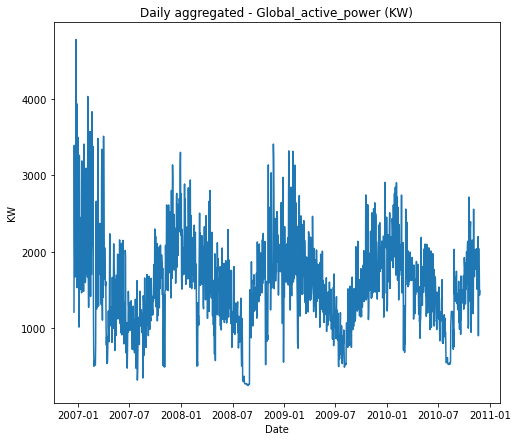

In [15]:
plt.figure(figsize = (8, 7))
plt.plot(data['datetime'], data["Global_active_power"], label = 'active power')
plt.title("Daily aggregated - Global_active_power (KW)")
# plt.legend()
plt.xlabel("Date")
plt.ylabel("KW")
plt.show()

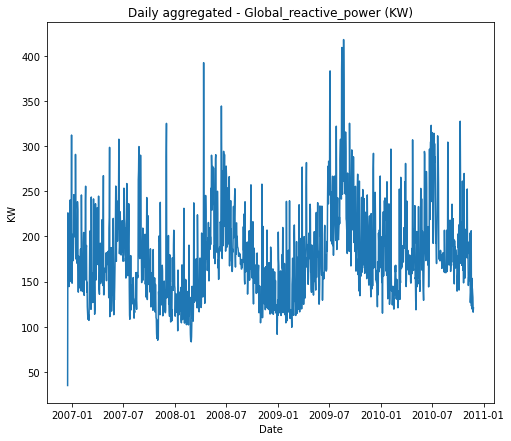

In [16]:
plt.figure(figsize = (8, 7))
plt.plot(data['datetime'], data['Global_reactive_power'], label = 'reactive power')
plt.title("Daily aggregated - Global_reactive_power (KW)")
plt.xlabel("Date")
plt.ylabel("KW")
plt.show()

#### Observation: 'Global_active_power' and 'Global_reactive_power' have different magnitudes!

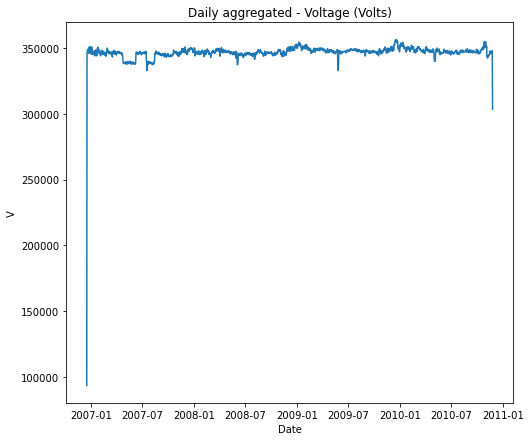

In [20]:
plt.figure(figsize = (8, 7))
plt.plot(data['datetime'], data['Voltage'])
plt.title("Daily aggregated - Voltage (Volts)")
plt.xlabel("Date")
plt.ylabel("V")
plt.show()

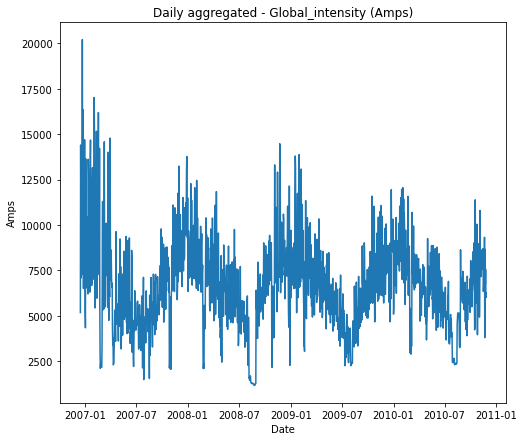

In [21]:
plt.figure(figsize = (8, 7))
plt.plot(data['datetime'], data['Global_intensity'])
plt.title("Daily aggregated - Global_intensity (Amps)")
plt.xlabel("Date")
plt.ylabel("Amps")
plt.show()

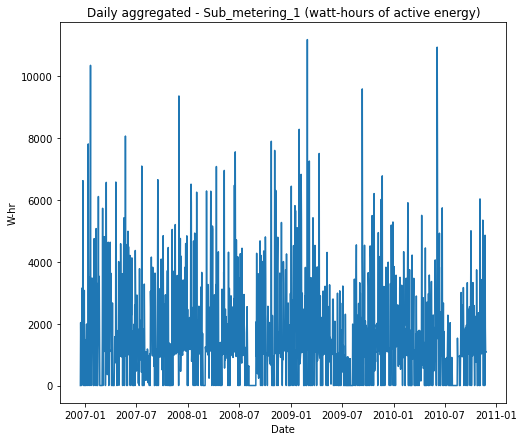

In [22]:
plt.figure(figsize = (8, 7))
plt.plot(data['datetime'], data['Sub_metering_1'])
plt.title("Daily aggregated - Sub_metering_1 (watt-hours of active energy)")
plt.xlabel("Date")
plt.ylabel("W-hr")
plt.show()

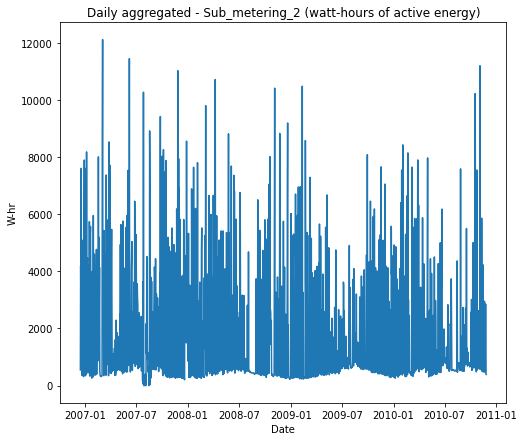

In [23]:
plt.figure(figsize = (8, 7))
plt.plot(data['datetime'], data['Sub_metering_2'])
plt.title("Daily aggregated - Sub_metering_2 (watt-hours of active energy)")
plt.xlabel("Date")
plt.ylabel("W-hr")
plt.show()

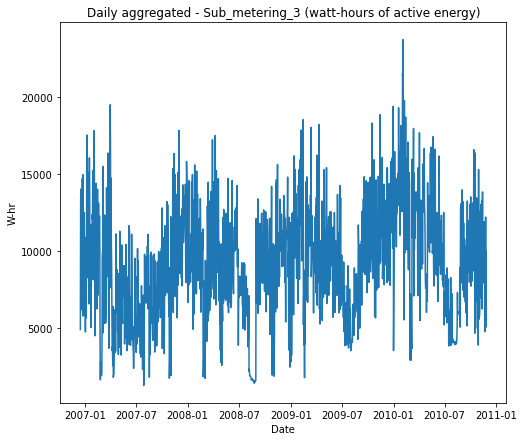

In [24]:
plt.figure(figsize = (8, 7))
plt.plot(data['datetime'], data['Sub_metering_3'])
plt.title("Daily aggregated - Sub_metering_3 (watt-hours of active energy)")
plt.xlabel("Date")
plt.ylabel("W-hr")
plt.show()

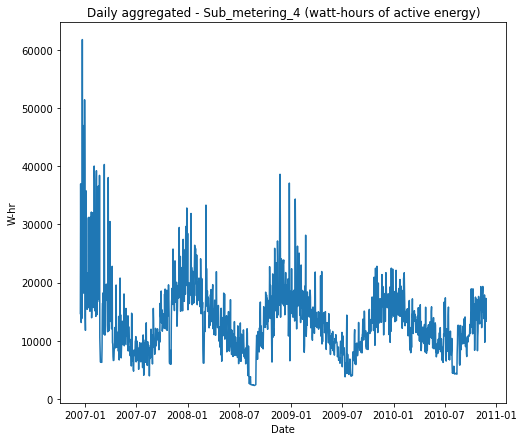

In [25]:
plt.figure(figsize = (8, 7))
plt.plot(data['datetime'], data['sub_metering_4'])
plt.title("Daily aggregated - Sub_metering_4 (watt-hours of active energy)")
plt.xlabel("Date")
plt.ylabel("W-hr")
plt.show()

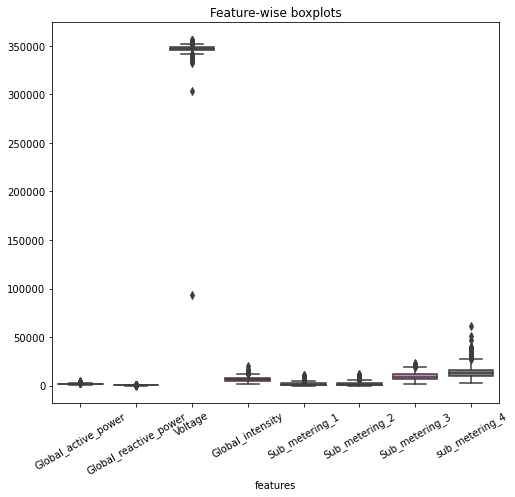

In [26]:
# Quick way to find the scales for different features-
plt.figure(figsize = (8, 7))
sns.boxplot(data = data)
plt.title("Feature-wise boxplots")
plt.xlabel("features")
plt.xticks(rotation = 30)
plt.show()

### Visualize distributions of different features

In [27]:
# Compute number of bins for visualizing histograms or distributions-
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins using rule of thumb = {num_bins}")

number of bins using rule of thumb = 38


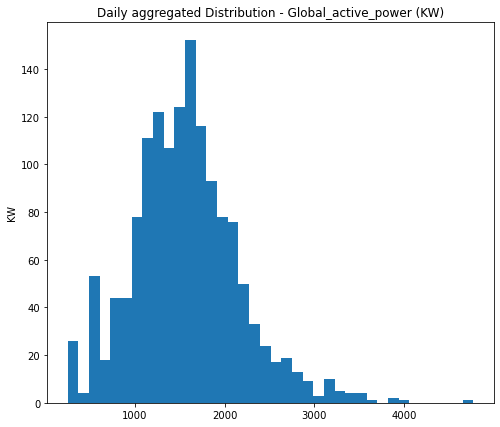

In [28]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data["Global_active_power"], bins=num_bins)
plt.title("Daily aggregated Distribution - Global_active_power (KW)")
plt.ylabel("KW")
plt.show()

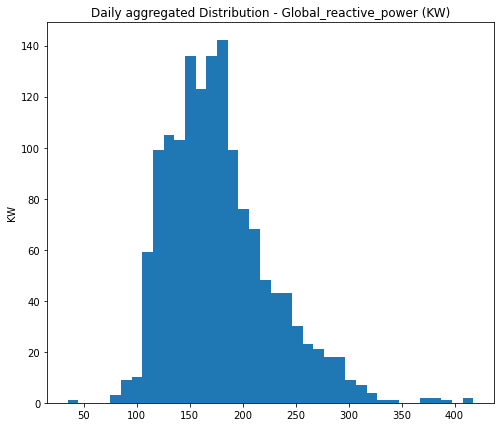

In [29]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data["Global_reactive_power"], bins=num_bins)
plt.title("Daily aggregated Distribution - Global_reactive_power (KW)")
plt.ylabel("KW")
plt.show()

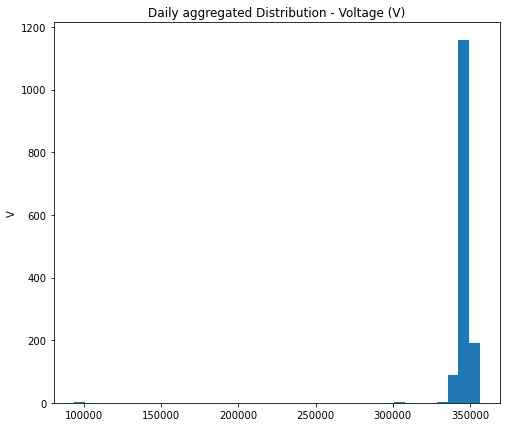

In [30]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data["Voltage"], bins=num_bins)
plt.title("Daily aggregated Distribution - Voltage (V)")
plt.ylabel("V")
plt.show()

Extemely left-skewed distribution!

In [34]:
print(f"Skew for 'Voltage' feature = {data['Voltage'].skew():.4f}")

Skew for 'Voltage' feature = -28.2486


In [35]:
print(f"Voltage: min = {data['Voltage'].min()} & max = {data['Voltage'].max()}")

Voltage: min = 93552.53 & max = 356306.4


In [36]:
# Get all Voltage values <= 100000-
data.loc[data['Voltage'] <= 100000, 'Voltage']

0    93552.53
Name: Voltage, dtype: float64

In [37]:
# Get all Voltage values <= 150000-
data.loc[data['Voltage'] <= 150000, 'Voltage']

0    93552.53
Name: Voltage, dtype: float64

In [38]:
# Get all Voltage values <= 200000-
data.loc[data['Voltage'] <= 200000, 'Voltage']

0    93552.53
Name: Voltage, dtype: float64

In [39]:
# Get all Voltage values <= 300000-
data.loc[data['Voltage'] <= 300000, 'Voltage']

0    93552.53
Name: Voltage, dtype: float64

In [41]:
# Get all Voltage values <= 350000-
data.loc[data['Voltage'] <= 350000, 'Voltage'].shape

(1312,)

In [43]:
# Get all Voltage values <= 100000-
data.loc[(data['Voltage'] >= 300000) & (data['Voltage'] <= 350000), 'Voltage'].shape

(1311,)

#### Observation:

__Because of just one voltage value = 93552.53, the distribution seems extremely left skewed!__

In [46]:
data.loc[(data['Voltage'] >= 300000) & (data['Voltage'] <= 350000), 'Voltage'].min()

303487.56

In [47]:
data.loc[(data['Voltage'] >= 300000) & (data['Voltage'] <= 350000), 'Voltage'].max()

349985.12

In [48]:
data.loc[(data['Voltage'] >= 300000) & (data['Voltage'] <= 350000), 'Voltage'].skew()

-4.006198607795619

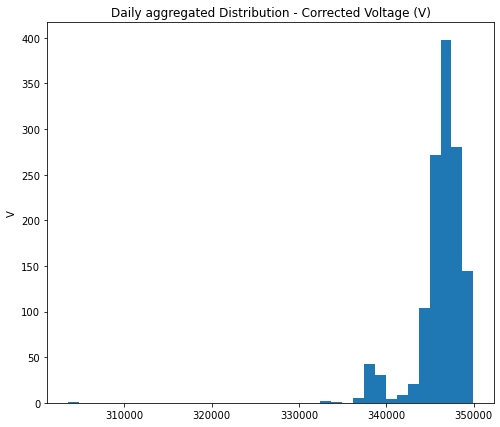

In [45]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data.loc[(data['Voltage'] >= 300000) & (data['Voltage'] <= 350000), 'Voltage'], bins = int(np.ceil(np.sqrt(1311))))
plt.title("Daily aggregated Distribution - Corrected Voltage (V)")
plt.ylabel("V")
plt.show()

In [49]:
data.loc[data['Voltage'] == 93552.53]

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934


#### NOTE:

One way of battling this skewed distribution is to drop/remove this one Voltage value of 93552.53. But, since the data has been aggregated from minutes to day, doing so will start the time-series from '2006-12-17' instead of '2006-12-16'!

In [55]:
data['datetime'].min(), data['datetime'].max()

(Timestamp('2006-12-16 00:00:00'), Timestamp('2010-11-26 00:00:00'))

In [56]:
data.loc[:5, 'datetime']

0   2006-12-16
1   2006-12-17
2   2006-12-18
3   2006-12-19
4   2006-12-20
5   2006-12-21
Name: datetime, dtype: datetime64[ns]

In [57]:
data.shape

(1442, 9)

In [17]:
# Remove this one voltage value to correct (a part of) skewness-
data = data[data['Voltage'] > 93552.53]

In [18]:
# Sanity check-
data.shape

(1441, 9)

In [19]:
# Further sanity check-
data['datetime'].min(), data['datetime'].max()

(Timestamp('2006-12-17 00:00:00'), Timestamp('2010-11-26 00:00:00'))

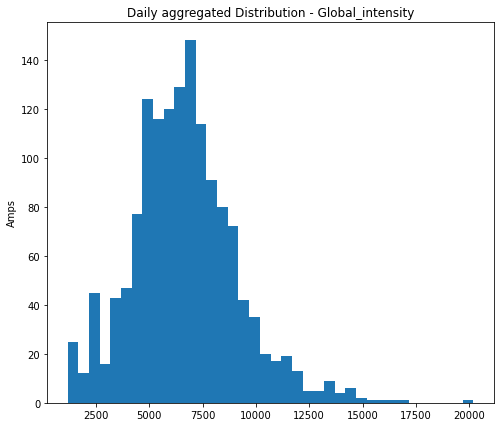

In [61]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data["Global_intensity"], bins=num_bins)
plt.title("Daily aggregated Distribution - Global_intensity")
plt.ylabel("Amps")
plt.show()

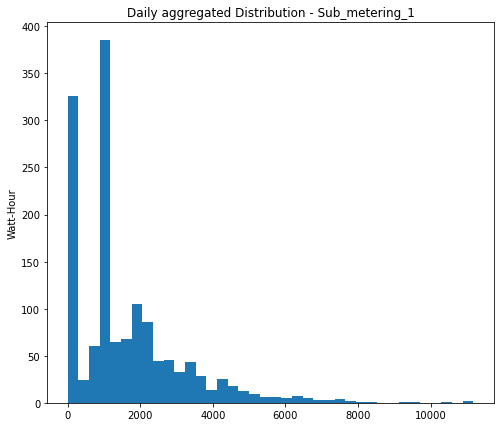

In [62]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data["Sub_metering_1"], bins=num_bins)
plt.title("Daily aggregated Distribution - Sub_metering_1")
plt.ylabel("Watt-Hour")
plt.show()

Right-skewed distribution

In [63]:
print(f"Skew for Sub metering 1 = {data['Sub_metering_1'].skew():.2f}")

Skew for Sub metering 1 = 1.73


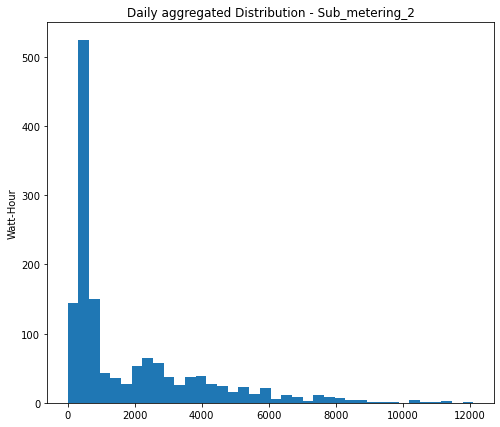

In [64]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data["Sub_metering_2"], bins=num_bins)
plt.title("Daily aggregated Distribution - Sub_metering_2")
plt.ylabel("Watt-Hour")
plt.show()

Right-skewed distribution

In [65]:
print(f"Skew for Sub metering 2 = {data['Sub_metering_2'].skew():.2f}")

Skew for Sub metering 2 = 1.70


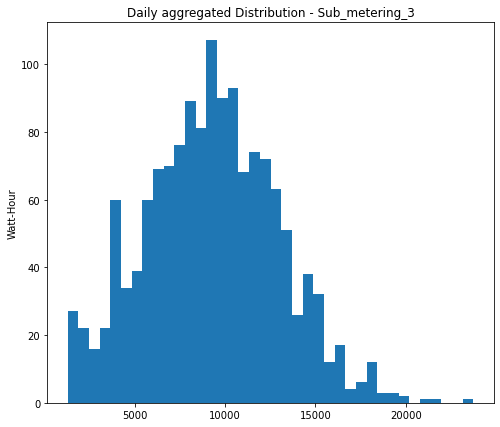

In [66]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data["Sub_metering_3"], bins=num_bins)
plt.title("Daily aggregated Distribution - Sub_metering_3")
plt.ylabel("Watt-Hour")
plt.show()

Almost Gaussian distribution

In [67]:
print(f"Skew for Sub metering 3 = {data['Sub_metering_3'].skew():.2f}")

Skew for Sub metering 3 = 0.15


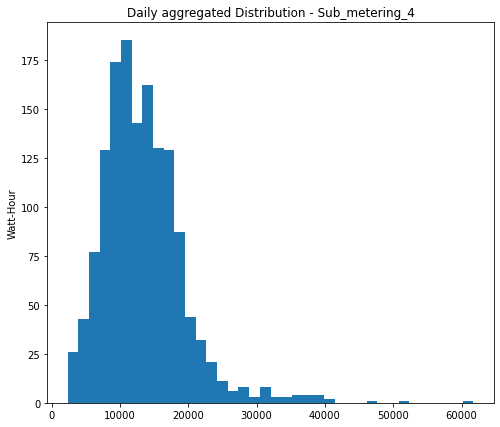

In [68]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data["sub_metering_4"], bins=num_bins)
plt.title("Daily aggregated Distribution - Sub_metering_4")
plt.ylabel("Watt-Hour")
plt.show()

Right-skewed distribution

In [69]:
print(f"Skew for Sub metering 4 = {data['sub_metering_4'].skew():.2f}")

Skew for Sub metering 4 = 1.63


In [17]:
# Calculate skewness for all numeric features-
for col in data.columns:
    if col == 'datetime':
        continue
    else:
        print(f"{col} has {data[col].skew():.4f} skew")

Global_active_power has 0.5771 skew
Global_reactive_power has 0.9970 skew
Voltage has -2.5632 skew
Global_intensity has 0.6078 skew
Sub_metering_1 has 1.7336 skew
Sub_metering_2 has 1.7048 skew
Sub_metering_3 has 0.1541 skew
sub_metering_4 has 1.6269 skew


In [18]:
# Get basic statistics for all numeric features-
data.iloc[:, 1:].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
count,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000
mean,1568.087969,178.104053,346776.135267,6647.604303,1610.773074,1859.045802,9283.596114,13381.384493
std,597.439408,48.752970,3153.176653,2472.665249,1581.706073,2085.598471,3674.398666,6073.795987
min,250.298000,83.248000,303487.560000,1164.000000,0.000000,0.000000,1288.000000,2313.633300
25%,1176.172000,143.108000,345737.780000,5054.800000,703.000000,432.000000,6684.000000,9395.033000
50%,1543.764000,171.200000,346980.500000,6543.000000,1120.000000,697.000000,9273.000000,12634.700000
75%,1894.598000,202.552000,348284.880000,7966.000000,2202.000000,2732.000000,11768.000000,16498.467000
max,4773.386000,417.834000,356306.400000,20200.400000,11178.000000,12109.000000,23743.000000,61736.434000


### Correlation between different numeric features

In [19]:
# Compute correlations using different methods-
corr_pearson = data.corr(method="pearson")
corr_kendall = data.corr(method="kendall")
corr_spearman = data.corr(method="spearman")

In [20]:
# Sanity check-
corr_pearson.shape, corr_kendall.shape, corr_spearman.shape

((8, 8), (8, 8), (8, 8))

In [21]:
# Get computed values of Pearson's Correlation matrix-
corr_pearson

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,0.041234,0.119258,0.999181,0.544894,0.482660,0.734258,0.887562
Global_reactive_power,0.041234,1.000000,-0.040691,0.063029,0.317786,0.183725,0.034644,-0.099202
Voltage,0.119258,-0.040691,1.000000,0.095555,-0.064677,-0.061454,0.166028,0.133015
Global_intensity,0.999181,0.063029,0.095555,1.000000,0.557567,0.492035,0.725747,0.884848
Sub_metering_1,0.544894,0.317786,-0.064677,0.557567,1.000000,0.251859,0.308765,0.359606
Sub_metering_2,0.482660,0.183725,-0.061454,0.492035,0.251859,1.000000,0.200869,0.260787
Sub_metering_3,0.734258,0.034644,0.166028,0.725747,0.308765,0.200869,1.000000,0.449395
sub_metering_4,0.887562,-0.099202,0.133015,0.884848,0.359606,0.260787,0.449395,1.000000


In [22]:
# Get computed values of Kendall's Rank Correlation matrix-
corr_kendall

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,-0.019137,0.085407,0.972407,0.415665,0.226331,0.567721,0.698652
Global_reactive_power,-0.019137,1.000000,-0.094274,-0.004483,0.163103,0.262766,0.002267,-0.132427
Voltage,0.085407,-0.094274,1.000000,0.066914,-0.042554,-0.125230,0.107001,0.120149
Global_intensity,0.972407,-0.004483,0.066914,1.000000,0.426337,0.238918,0.559782,0.690774
Sub_metering_1,0.415665,0.163103,-0.042554,0.426337,1.000000,0.177559,0.245931,0.293397
Sub_metering_2,0.226331,0.262766,-0.125230,0.238918,0.177559,1.000000,0.090168,0.080106
Sub_metering_3,0.567721,0.002267,0.107001,0.559782,0.245931,0.090168,1.000000,0.349807
sub_metering_4,0.698652,-0.132427,0.120149,0.690774,0.293397,0.080106,0.349807,1.000000


In [23]:
# Get computed values of Spearman's Rank Correlation matrix-
corr_spearman

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,-0.028386,0.128672,0.998828,0.573915,0.335017,0.752336,0.875617
Global_reactive_power,-0.028386,1.000000,-0.139699,-0.006577,0.239760,0.371229,0.002563,-0.193590
Voltage,0.128672,-0.139699,1.000000,0.100836,-0.062950,-0.181428,0.161519,0.181091
Global_intensity,0.998828,-0.006577,0.100836,1.000000,0.587337,0.352151,0.743882,0.869098
Sub_metering_1,0.573915,0.239760,-0.062950,0.587337,1.000000,0.263449,0.350065,0.414276
Sub_metering_2,0.335017,0.371229,-0.181428,0.352151,0.263449,1.000000,0.129670,0.120222
Sub_metering_3,0.752336,0.002563,0.161519,0.743882,0.350065,0.129670,1.000000,0.497440
sub_metering_4,0.875617,-0.193590,0.181091,0.869098,0.414276,0.120222,0.497440,1.000000


In [24]:
# Filter for correlation values >= 0.5-
corr_spearman[corr_spearman >= 0.5]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,NaN,NaN,0.998828,0.573915,NaN,0.752336,0.875617
Global_reactive_power,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Voltage,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Global_intensity,0.998828,NaN,NaN,1.000000,0.587337,NaN,0.743882,0.869098
Sub_metering_1,0.573915,NaN,NaN,0.587337,1.000000,NaN,NaN,NaN
Sub_metering_2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Sub_metering_3,0.752336,NaN,NaN,0.743882,NaN,NaN,1.000000,NaN
sub_metering_4,0.875617,NaN,NaN,0.869098,NaN,NaN,NaN,1.000000


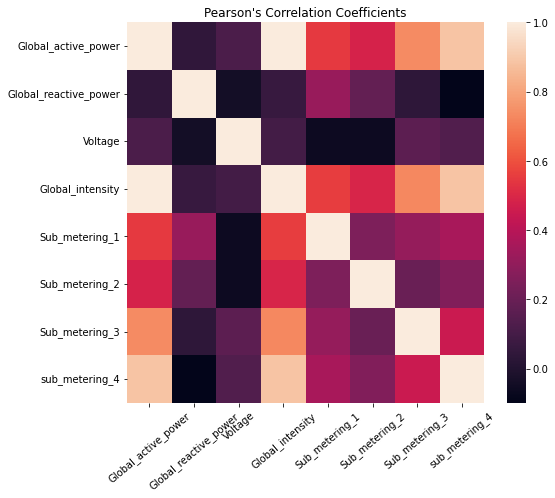

In [25]:
# Visualize correlation obtained above-
plt.figure(figsize = (8, 7))
sns.heatmap(data = corr_pearson)
plt.xticks(rotation = 40)
plt.title("Pearson's Correlation Coefficients")
plt.show()

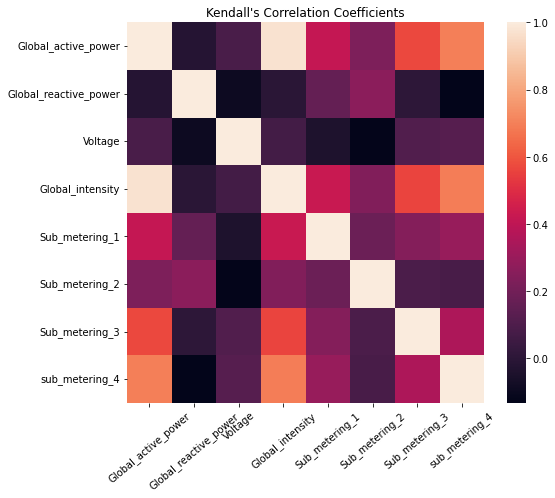

In [26]:
plt.figure(figsize = (8, 7))
sns.heatmap(data = corr_kendall)
plt.xticks(rotation = 40)
plt.title("Kendall's Correlation Coefficients")
plt.show()

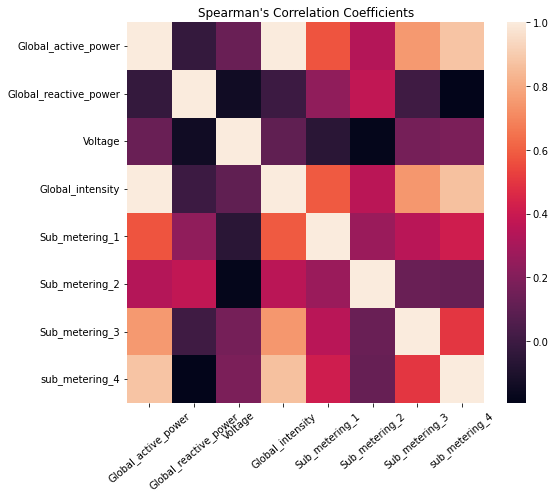

In [27]:
plt.figure(figsize = (8, 7))
sns.heatmap(data = corr_spearman)
plt.xticks(rotation = 40)
plt.title("Spearman's Correlation Coefficients")
plt.show()

### Visualize scatter plot for strongly correlated variables using correlations from above

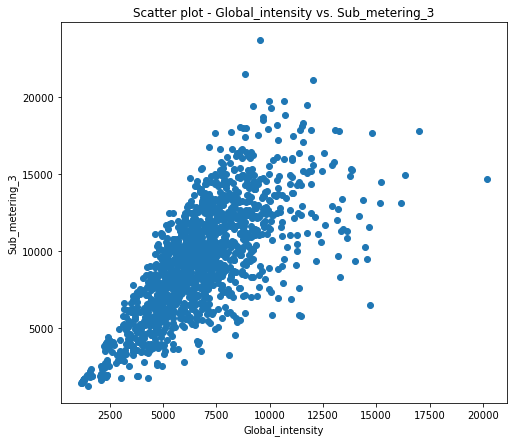

In [26]:
plt.figure(figsize = (8, 7))
plt.scatter(x = data["Global_intensity"], y = data["Sub_metering_3"])
plt.xlabel("Global_intensity")
plt.ylabel("Sub_metering_3")
plt.title("Scatter plot - Global_intensity vs. Sub_metering_3")
plt.show()

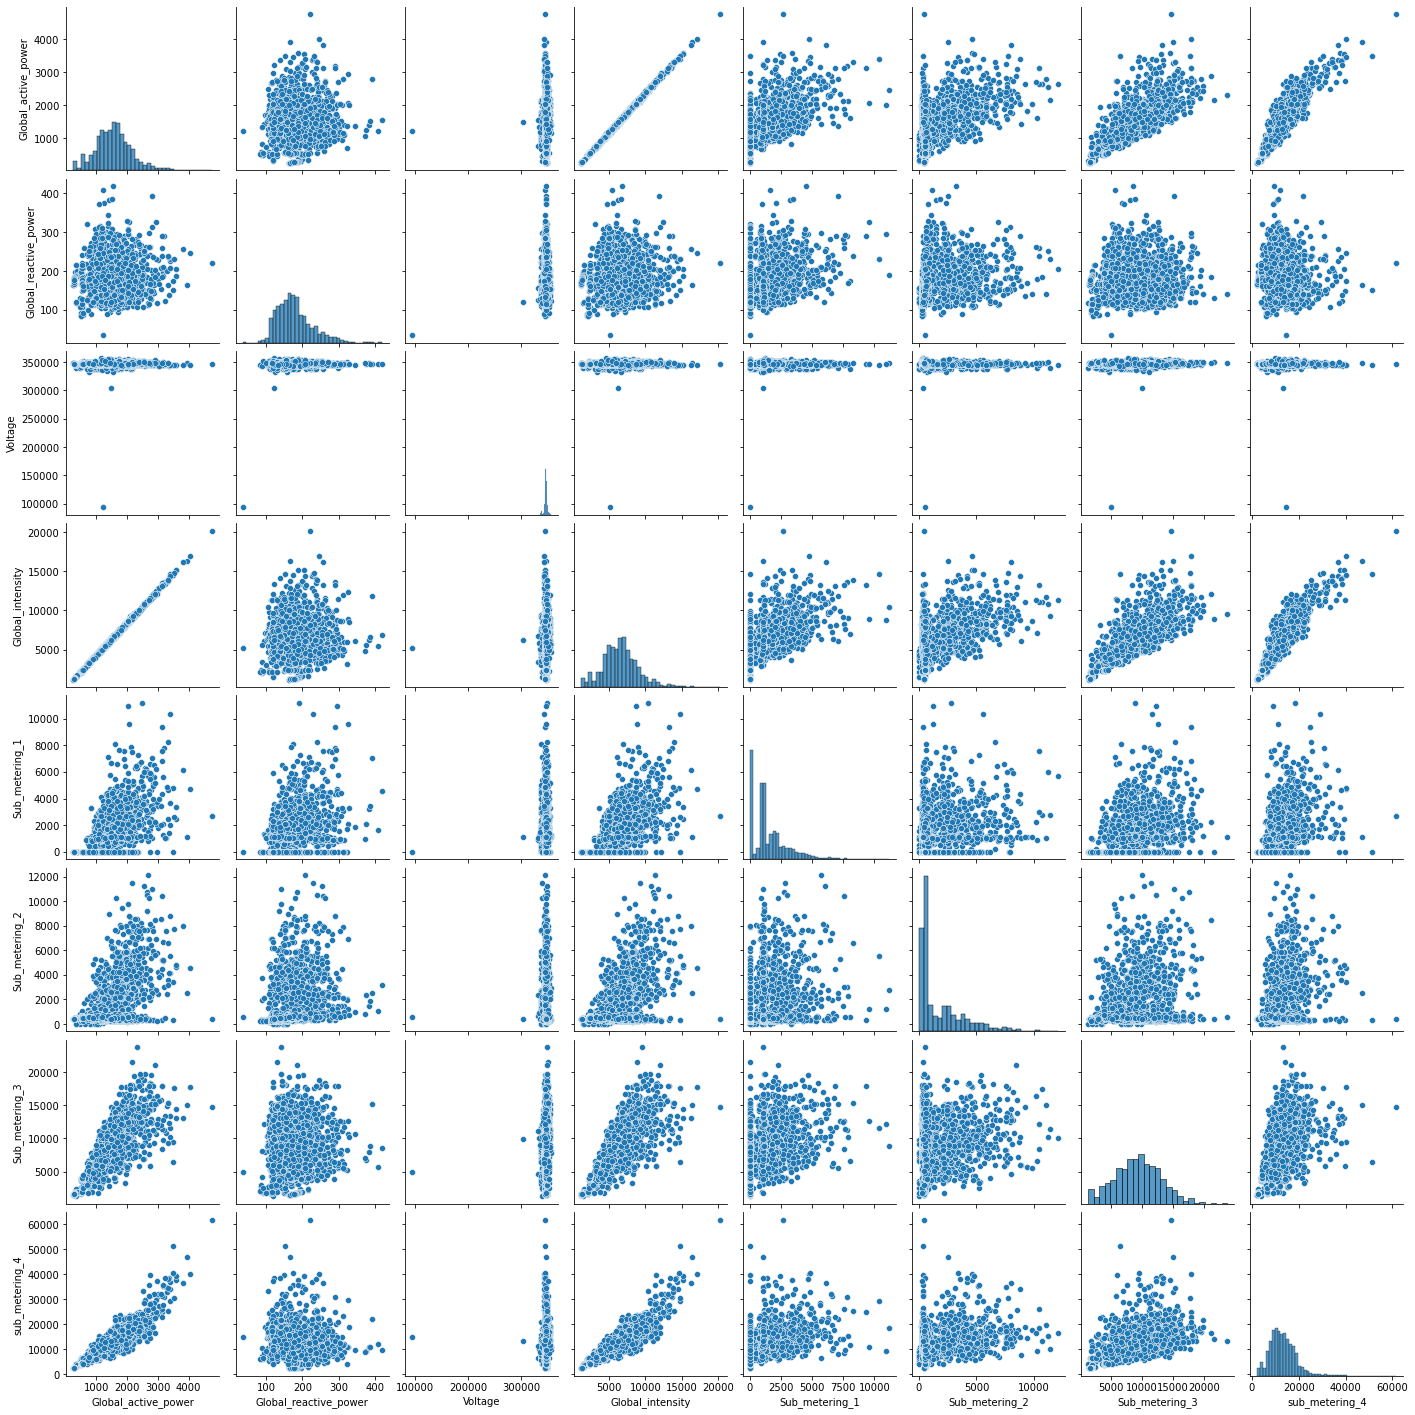

In [44]:
# The simplest invocation uses 'sns.scatterplot()' for each pairing of the variables and
# 'histplot()' for the marginal plots along the diagonal-
# plt.figure(figsize = (10, 9))
sns.pairplot(data = data)
plt.show()

#### Scale different numeric features

In [20]:
std_scaler = StandardScaler()

# Exclude 'datetime' attribute from scaling-
data_scaled = std_scaler.fit_transform(data.iloc[:, 1:])

In [21]:
# Sanity check-
data_scaled.shape, data.shape

((1441, 8), (1441, 9))

In [22]:
# Sanity check-
data_scaled[:5, :]

array([[ 3.05136331,  0.98288529, -0.33337811,  3.13576072,  0.26703666,
         1.11659191,  1.10461951,  3.88117489],
       [ 1.06447403, -0.33470199,  0.18955239,  1.05169844, -0.3464381 ,
         0.36546762,  1.28893131,  0.93006251],
       [ 0.16426786, -0.55732979,  0.54023485,  0.18059487, -0.48810649,
         2.75458005, -0.84031918, -0.04108981],
       [ 1.10118003, -0.35099383,  0.6812908 ,  1.07831864, -1.01873053,
         0.37841804,  1.30118246,  1.15345442],
       [ 0.25986553, -0.69086544,  0.10160418,  0.25034142,  0.09754054,
         0.39952243,  0.31918445,  0.07033999]])

In [23]:
data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
1,2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2,2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
3,2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
4,2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800
5,2006-12-21,1723.288,144.434,347096.40,7266.4,1765.0,2692.0,10456.0,13808.467


In [24]:
# Extract 'datetime' variable-
date_time_idx = data['datetime']

In [25]:
date_time_idx.loc[:5]

1   2006-12-17
2   2006-12-18
3   2006-12-19
4   2006-12-20
5   2006-12-21
Name: datetime, dtype: datetime64[ns]

In [26]:
data.drop(labels = ['datetime'], axis = 1, inplace = True)

In [27]:
data.shape

(1441, 8)

In [28]:
data.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'sub_metering_4'],
      dtype='object')

In [29]:
data.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
1,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
3,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
4,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800
5,1723.288,144.434,347096.40,7266.4,1765.0,2692.0,10456.0,13808.467
6,2341.338,186.906,347305.75,9897.0,3151.0,350.0,11131.0,24390.300
7,4773.386,221.470,345795.94,20200.4,2669.0,425.0,14726.0,61736.434
8,2550.012,149.900,348029.90,11002.2,1703.0,5082.0,6891.0,28824.200
9,2743.120,240.280,350495.90,11450.2,6620.0,1962.0,5795.0,31341.666
10,3934.110,165.102,347940.62,16341.0,1086.0,2533.0,14979.0,46970.500


In [32]:
# Specify number of past values to be used for training-
look_back = 14

# Specify number of future values to be predicted-
future_window = 7

In [30]:
def slicer(data, look_back = 10, future_window = 3):
    '''
    Create features and labels required for Multivariate Multi-step
    Forecasting by Seq2Seq deep learning models
    '''
    # Python3 lists to contain training data and target-
    X, y = list(), list()
    
    # Counter to loop through the 2-D matrix dataset to create 'X' and 'y'-
    i = look_back
    
    while i <= (len(data) - future_window):
        # X.append(data.iloc[i - look_back: i, 1:])
        X.append(data[i - look_back: i, 1:])
    
        # This does NOT include the current target value for 'i' but rather
        # i + 1 and i + 2-
        # X[i: i + future_window, 2]
        # y.append(data.iloc[i: i + future_window, 0])
        y.append(data[i: i + future_window, 0])
    
        # This INCLUDES the current target value for 'i', as in-
        # i and i + 1-
        # X[i - 1: i + future_window - 1, 2]
    
        i += 1

    # Convert from list to np arrays-
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y


In [33]:
# Get features 'X' and labels 'y' using processed data-
X, y = slicer(
    data = data_scaled,
    look_back = look_back, future_window = future_window
)

In [34]:
# Sanity check-
X.shape, y.shape

((1421, 14, 7), (1421, 7))

In [ ]:
"""
# Specify number of past values to be used for training-
look_back = 14

# Specify number of future values to be predicted-
future_window = 7

# Python3 lists to contain training data and target-
X, y = list(), list()

# Loop through the 2-D matrix dataset to create 'X' and 'y'-
i = look_back

while i <= (len(data) - future_window):
    
    X.append(data.iloc[i - look_back: i, 1:])
    
    # This does NOT include the current target value for 'i' but rather
    # i + 1 and i + 2-
    # x[i: i + future_window, 2]
    y.append(data.iloc[i: i + future_window, 0])
    
    # This INCLUDES the current target value for 'i', as in-
    # i and i + 1-
    # x[i - 1: i + future_window - 1, 2]
    
    i += 1

    
# Convert from list to np arrays-
X = np.asarray(X)
y = np.asarray(y)

"""

In [35]:
len(data), len(X), look_back, future_window

(1441, 1421, 14, 7)

In [36]:
len(data) == look_back + len(X)

False

In [37]:
len(data) - len(X)

20

In [38]:
data_scaled[:14, :]

array([[ 3.05136331,  0.98288529, -0.33337811,  3.13576072,  0.26703666,
         1.11659191,  1.10461951,  3.88117489],
       [ 1.06447403, -0.33470199,  0.18955239,  1.05169844, -0.3464381 ,
         0.36546762,  1.28893131,  0.93006251],
       [ 0.16426786, -0.55732979,  0.54023485,  0.18059487, -0.48810649,
         2.75458005, -0.84031918, -0.04108981],
       [ 1.10118003, -0.35099383,  0.6812908 ,  1.07831864, -1.01873053,
         0.37841804,  1.30118246,  1.15345442],
       [ 0.25986553, -0.69086544,  0.10160418,  0.25034142,  0.09754054,
         0.39952243,  0.31918445,  0.07033999],
       [ 1.29472289,  0.18060444,  0.16802059,  1.31458303,  0.97411375,
        -0.72380648,  0.50295175,  1.81315563],
       [ 5.36692214,  0.8898125 , -0.31096753,  5.48295032,  0.66927372,
        -0.68783309,  1.48168279,  7.96402063],
       [ 1.64412475, -0.57871027,  0.3977576 ,  1.76170529,  0.05832875,
         1.5458743 , -0.65137916,  2.54341382],
       [ 1.96746305,  1.27576909

In [39]:
X[0]

array([[ 0.98288529, -0.33337811,  3.13576072,  0.26703666,  1.11659191,
         1.10461951,  3.88117489],
       [-0.33470199,  0.18955239,  1.05169844, -0.3464381 ,  0.36546762,
         1.28893131,  0.93006251],
       [-0.55732979,  0.54023485,  0.18059487, -0.48810649,  2.75458005,
        -0.84031918, -0.04108981],
       [-0.35099383,  0.6812908 ,  1.07831864, -1.01873053,  0.37841804,
         1.30118246,  1.15345442],
       [-0.69086544,  0.10160418,  0.25034142,  0.09754054,  0.39952243,
         0.31918445,  0.07033999],
       [ 0.18060444,  0.16802059,  1.31458303,  0.97411375, -0.72380648,
         0.50295175,  1.81315563],
       [ 0.8898125 , -0.31096753,  5.48295032,  0.66927372, -0.68783309,
         1.48168279,  7.96402063],
       [-0.57871027,  0.3977576 ,  1.76170529,  0.05832875,  1.5458743 ,
        -0.65137916,  2.54341382],
       [ 1.27576909,  1.18009757,  1.9429492 ,  3.16807656,  0.04938148,
        -0.94976282,  2.95803756],
       [-0.26678512,  0.3694

In [40]:
data_scaled[14: 22, 0]

array([ 3.22505793,  1.97731516, -0.50039504, -0.92766948,  2.83193772,
        1.91763987, -0.09997783,  1.47268051])

In [41]:
y[:14]

array([[ 3.22505793,  1.97731516, -0.50039504, -0.92766948,  2.83193772,
         1.91763987, -0.09997783],
       [ 1.97731516, -0.50039504, -0.92766948,  2.83193772,  1.91763987,
        -0.09997783,  1.47268051],
       [-0.50039504, -0.92766948,  2.83193772,  1.91763987, -0.09997783,
         1.47268051,  1.12732062],
       [-0.92766948,  2.83193772,  1.91763987, -0.09997783,  1.47268051,
         1.12732062,  0.50393481],
       [ 2.83193772,  1.91763987, -0.09997783,  1.47268051,  1.12732062,
         0.50393481,  0.98238534],
       [ 1.91763987, -0.09997783,  1.47268051,  1.12732062,  0.50393481,
         0.98238534,  1.15048415],
       [-0.09997783,  1.47268051,  1.12732062,  0.50393481,  0.98238534,
         1.15048415, -0.17881151],
       [ 1.47268051,  1.12732062,  0.50393481,  0.98238534,  1.15048415,
        -0.17881151,  2.71038028],
       [ 1.12732062,  0.50393481,  0.98238534,  1.15048415, -0.17881151,
         2.71038028,  2.4133902 ],
       [ 0.50393481,  0.9823

### Define _Seq2Seq_ architecture

Bidirectional wrapper for RNNs: [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [42]:
def Stacked_LSTM(X, y):
    # Function to define stacked LSTM architecture.
    model = Sequential()

    # Stack of LSTMs-
    model.add(
        LSTM(
            units = 64, activation = 'relu',
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = True
        )
    )
    # return sequence for the next LSTM to process.
    
    model.add(
        LSTM(
            units = 64, activation = 'relu',
            return_sequences = True
        )
    )

    model.add(
        LSTM(
            units = 32, activation = 'relu',
            return_sequences = False
        )
    )

    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [44]:
def Stacked_Bi_LSTM(X, y):
    # Function to define stacked Bidirectional LSTM architecture.
    model = Sequential()
    
    model.add(
        Bidirectional(
            LSTM(units = 64, return_sequences = True), input_shape = (X.shape[1], X.shape[2])
        )
    )
    
    model.add(
        Bidirectional(
            LSTM(units = 64, return_sequences = True)
        )
    )
    
    model.add(
        Bidirectional(
            LSTM(units = 32, return_sequences = False)
        )
    )
    
    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model



In [49]:
def Stacked_GRU(X, y):
    # Function to define stacked GRU architecture.
    model = Sequential()

    # Stack of LSTMs-
    model.add(
        GRU(
            units = 64, activation = 'tanh',
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = True, return_state = False
        )
    )
    # return sequence for the next GRU to process.
    
    model.add(
        GRU(
            units = 64, activation = 'tanh',
            return_sequences = True, return_state = False
        )
    )

    model.add(
        GRU(
            units = 32, activation = 'tanh',
            return_sequences = False
        )
    )

    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [50]:
def Stacked_Bi_GRU(X, y):
    # Function to define stacked Bidirectional GRU architecture.
    model = Sequential()
    
    model.add(
        Bidirectional(
            GRU(units = 64, return_sequences = True), input_shape = (X.shape[1], X.shape[2])
        )
    )
    
    model.add(
        Bidirectional(
            GRU(units = 64, return_sequences = True)
        )
    )
    
    model.add(
        Bidirectional(
            GRU(units = 32, return_sequences = False)
        )
    )
    
    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [47]:
# Instantiate a stacked LSTM instance-
model_lstm = Stacked_LSTM(X = X, y = y)

In [48]:
# Instantiate a stacked Bidirectional LSTM instance-
model_bi_lstm = Stacked_Bi_LSTM(X = X, y = y)

In [51]:
# Instantiate a GRU instance architecture-
model_gru = Stacked_GRU(X = X, y = y)

In [52]:
# Instantiate a stacked Bidirectional GRU instance-
model_bi_gru = Stacked_Bi_GRU(X = X, y = y)

In [53]:
# Compile defined architecture-
model_lstm.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [54]:
# Compile defined architecture-
model_bi_lstm.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [55]:
# Compile defined architecture-
model_gru.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [56]:
# Compile defined architecture-
model_bi_gru.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [57]:
# Get model summary-
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            18432     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 64,103
Trainable params: 64,103
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Get model summary-
model_bi_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 14, 128)          36864     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 14, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                      

In [59]:
# Get model summary-
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 64)            14016     
                                                                 
 gru_1 (GRU)                 (None, 14, 64)            24960     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 48,615
Trainable params: 48,615
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Get model summary-
model_bi_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 14, 128)          28032     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 14, 128)          74496     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                      

In [61]:
# Count number of trainable parameters manually-
tot_params_lstm = 0

for layer in model_lstm.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params_lstm += loc_params
    print(f"layer: {layer.shape} has {loc_params} weights")

layer: (7, 256) has 1792 weights
layer: (64, 256) has 16384 weights
layer: (256,) has 64 weights
layer: (64, 256) has 16384 weights
layer: (64, 256) has 16384 weights
layer: (256,) has 64 weights
layer: (64, 128) has 8192 weights
layer: (32, 128) has 4096 weights
layer: (128,) has 32 weights
layer: (32, 7) has 224 weights
layer: (7,) has 0 weights


In [62]:
# Count number of trainable parameters manually-
tot_params_bi_lstm = 0

for layer in model_bi_lstm.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params_bi_lstm += loc_params
    print(f"layer: {layer.shape} has {loc_params} weights")

layer: (7, 256) has 1792 weights
layer: (64, 256) has 16384 weights
layer: (256,) has 64 weights
layer: (7, 256) has 1792 weights
layer: (64, 256) has 16384 weights
layer: (256,) has 64 weights
layer: (128, 256) has 32768 weights
layer: (64, 256) has 16384 weights
layer: (256,) has 64 weights
layer: (128, 256) has 32768 weights
layer: (64, 256) has 16384 weights
layer: (256,) has 64 weights
layer: (128, 128) has 16384 weights
layer: (32, 128) has 4096 weights
layer: (128,) has 32 weights
layer: (128, 128) has 16384 weights
layer: (32, 128) has 4096 weights
layer: (128,) has 32 weights
layer: (64, 7) has 448 weights
layer: (7,) has 0 weights


In [63]:
# Count number of trainable parameters manually-
tot_params_gru = 0

for layer in model_gru.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params_gru += loc_params
    print(f"layer: {layer.shape} has {loc_params} weights")

layer: (7, 192) has 1344 weights
layer: (64, 192) has 12288 weights
layer: (2, 192) has 0 weights
layer: (64, 192) has 12288 weights
layer: (64, 192) has 12288 weights
layer: (2, 192) has 0 weights
layer: (64, 96) has 6144 weights
layer: (32, 96) has 3072 weights
layer: (2, 96) has 0 weights
layer: (32, 7) has 224 weights
layer: (7,) has 0 weights


In [65]:
# Count number of trainable parameters manually-
tot_params_bi_gru = 0

for layer in model_bi_gru.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params_bi_gru += loc_params
    print(f"layer: {layer.shape} has {loc_params} weights")

layer: (7, 192) has 1344 weights
layer: (64, 192) has 12288 weights
layer: (2, 192) has 0 weights
layer: (7, 192) has 1344 weights
layer: (64, 192) has 12288 weights
layer: (2, 192) has 0 weights
layer: (128, 192) has 24576 weights
layer: (64, 192) has 12288 weights
layer: (2, 192) has 0 weights
layer: (128, 192) has 24576 weights
layer: (64, 192) has 12288 weights
layer: (2, 192) has 0 weights
layer: (128, 96) has 12288 weights
layer: (32, 96) has 3072 weights
layer: (2, 96) has 0 weights
layer: (128, 96) has 12288 weights
layer: (32, 96) has 3072 weights
layer: (2, 96) has 0 weights
layer: (64, 7) has 448 weights
layer: (7,) has 0 weights


In [66]:
print(f"Stacked LSTM architecture has {tot_params_lstm} trainable parameters")
print(f"Stacked GRU architecture has {tot_params_gru} trainable parameters")

Stacked LSTM architecture has 63616 trainable parameters
Stacked GRU architecture has 47648 trainable parameters


In [67]:
print(f"Stacked Bidirectional LSTM architecture has {tot_params_bi_lstm} trainable parameters")
print(f"Stacked Bidirectional GRU architecture has {tot_params_bi_gru} trainable parameters")

Stacked Bidirectional LSTM architecture has 176384 trainable parameters
Stacked Bidirectional GRU architecture has 132160 trainable parameters


In [68]:
# Define EarlyStopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.001,
    patience = 10, verbose = 0,
    mode = 'auto', baseline = None,
    restore_best_weights = True
)

In [69]:
# Train LSTM model-
train_history_lstm = model_lstm.fit(
    x = X, y = y,
    epochs = 50, batch_size = 32,
    validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping]
)

Epoch 1/50
40/40 [==============================] - 11s 71ms/step - loss: 0.9645 - val_loss: 0.4871
Epoch 2/50
40/40 [==============================] - 2s 42ms/step - loss: 0.6858 - val_loss: 0.3372
Epoch 3/50
40/40 [==============================] - 2s 42ms/step - loss: 0.6571 - val_loss: 0.3776
Epoch 4/50
40/40 [==============================] - 2s 42ms/step - loss: 0.6190 - val_loss: 0.3258
Epoch 5/50
40/40 [==============================] - 2s 42ms/step - loss: 0.5691 - val_loss: 0.3829
Epoch 6/50
40/40 [==============================] - 2s 42ms/step - loss: 0.5712 - val_loss: 0.3229
Epoch 7/50
40/40 [==============================] - 2s 42ms/step - loss: 0.5350 - val_loss: 0.3215
Epoch 8/50
40/40 [==============================] - 2s 42ms/step - loss: 0.5169 - val_loss: 0.3879
Epoch 9/50
40/40 [==============================] - 2s 42ms/step - loss: 0.5187 - val_loss: 0.4102
Epoch 10/50
40/40 [==============================] - 2s 43ms/step - loss: 0.5165 - val_loss: 0.3150
Epoch 11

In [70]:
# Train Bidirectional LSTM model-
train_history_bi_lstm = model_bi_lstm.fit(
    x = X, y = y,
    epochs = 50, batch_size = 32,
    validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping]
)

Epoch 1/50
40/40 [==============================] - 29s 187ms/step - loss: 0.6600 - val_loss: 0.3002
Epoch 2/50
40/40 [==============================] - 2s 49ms/step - loss: 0.5744 - val_loss: 0.3137
Epoch 3/50
40/40 [==============================] - 2s 50ms/step - loss: 0.5344 - val_loss: 0.3397
Epoch 4/50
40/40 [==============================] - 2s 50ms/step - loss: 0.5138 - val_loss: 0.3761
Epoch 5/50
40/40 [==============================] - 2s 50ms/step - loss: 0.4720 - val_loss: 0.3178
Epoch 6/50
40/40 [==============================] - 2s 51ms/step - loss: 0.4623 - val_loss: 0.3394
Epoch 7/50
40/40 [==============================] - 2s 50ms/step - loss: 0.4063 - val_loss: 0.3376
Epoch 8/50
40/40 [==============================] - 2s 49ms/step - loss: 0.3650 - val_loss: 0.3852
Epoch 9/50
40/40 [==============================] - 2s 49ms/step - loss: 0.3111 - val_loss: 0.3831
Epoch 10/50
40/40 [==============================] - 2s 49ms/step - loss: 0.2830 - val_loss: 0.3807
Epoch 1

In [71]:
# Train GRU model-
train_history_gru = model_gru.fit(
    x = X, y = y,
    epochs = 50, batch_size = 32,
    validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping]
)

Epoch 1/50
40/40 [==============================] - 17s 113ms/step - loss: 0.6707 - val_loss: 0.3464
Epoch 2/50
40/40 [==============================] - 2s 54ms/step - loss: 0.5859 - val_loss: 0.3169
Epoch 3/50
40/40 [==============================] - 2s 54ms/step - loss: 0.5412 - val_loss: 0.4123
Epoch 4/50
40/40 [==============================] - 2s 54ms/step - loss: 0.4739 - val_loss: 0.4221
Epoch 5/50
40/40 [==============================] - 2s 43ms/step - loss: 0.3997 - val_loss: 0.4062
Epoch 6/50
40/40 [==============================] - 2s 39ms/step - loss: 0.3284 - val_loss: 0.3702
Epoch 7/50
40/40 [==============================] - 2s 49ms/step - loss: 0.2803 - val_loss: 0.4234
Epoch 8/50
40/40 [==============================] - 2s 47ms/step - loss: 0.2375 - val_loss: 0.3922
Epoch 9/50
40/40 [==============================] - 2s 49ms/step - loss: 0.2047 - val_loss: 0.3468
Epoch 10/50
40/40 [==============================] - 2s 49ms/step - loss: 0.1856 - val_loss: 0.4094
Epoch 1

In [72]:
# Train Bidirectional GRU model-
train_history_bi_gru = model_bi_gru.fit(
    x = X, y = y,
    epochs = 50, batch_size = 32,
    validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping]
)

Epoch 1/50
40/40 [==============================] - 31s 187ms/step - loss: 0.6821 - val_loss: 0.3393
Epoch 2/50
40/40 [==============================] - 2s 50ms/step - loss: 0.5858 - val_loss: 0.4170
Epoch 3/50
40/40 [==============================] - 2s 51ms/step - loss: 0.5215 - val_loss: 0.3989
Epoch 4/50
40/40 [==============================] - 2s 50ms/step - loss: 0.4645 - val_loss: 0.3784
Epoch 5/50
40/40 [==============================] - 2s 50ms/step - loss: 0.3881 - val_loss: 0.3937
Epoch 6/50
40/40 [==============================] - 2s 50ms/step - loss: 0.2903 - val_loss: 0.4135
Epoch 7/50
40/40 [==============================] - 2s 51ms/step - loss: 0.2371 - val_loss: 0.4646
Epoch 8/50
40/40 [==============================] - 2s 50ms/step - loss: 0.2053 - val_loss: 0.4904
Epoch 9/50
40/40 [==============================] - 2s 50ms/step - loss: 0.1811 - val_loss: 0.3973
Epoch 10/50
40/40 [==============================] - 2s 50ms/step - loss: 0.1599 - val_loss: 0.4176
Epoch 1

### Visualize training metrics

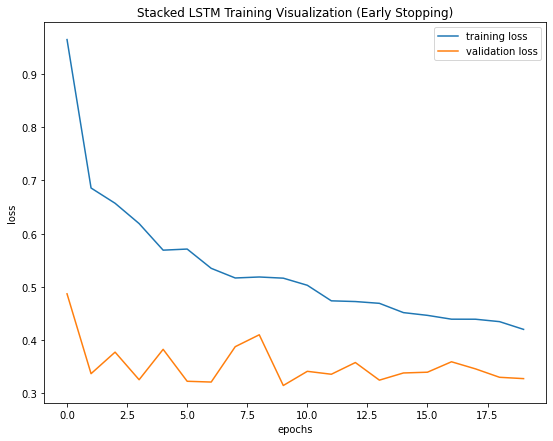

In [74]:
# Visualize LSTM training-
plt.figure(figsize = (9, 7))
plt.plot(train_history_lstm.history['loss'], label = 'training loss')
plt.plot(train_history_lstm.history['val_loss'], label = 'validation loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Stacked LSTM Training Visualization (Early Stopping)")
plt.show()

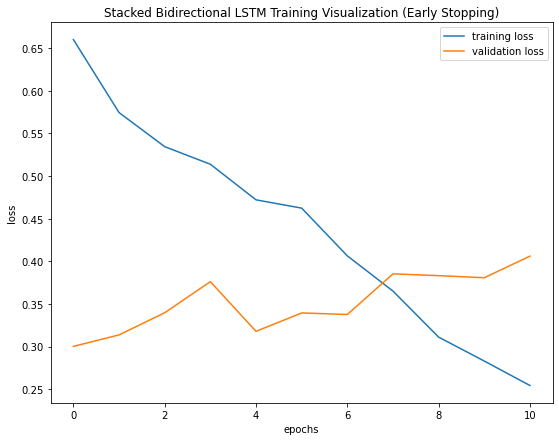

In [75]:
# Visualize LSTM training-
plt.figure(figsize = (9, 7))
plt.plot(train_history_bi_lstm.history['loss'], label = 'training loss')
plt.plot(train_history_bi_lstm.history['val_loss'], label = 'validation loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Stacked Bidirectional LSTM Training Visualization (Early Stopping)")
plt.show()

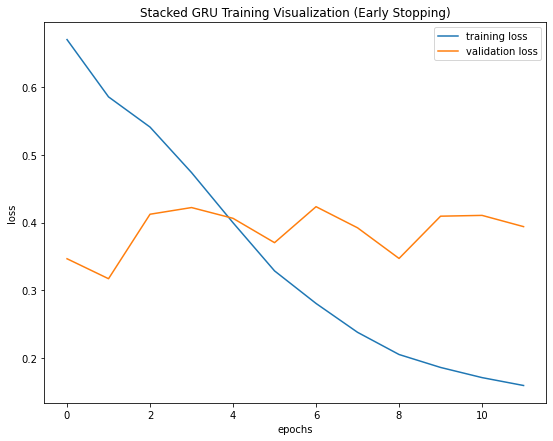

In [76]:
# Visualize LSTM training-
plt.figure(figsize = (9, 7))
plt.plot(train_history_gru.history['loss'], label = 'training loss')
plt.plot(train_history_gru.history['val_loss'], label = 'validation loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Stacked GRU Training Visualization (Early Stopping)")
plt.show()

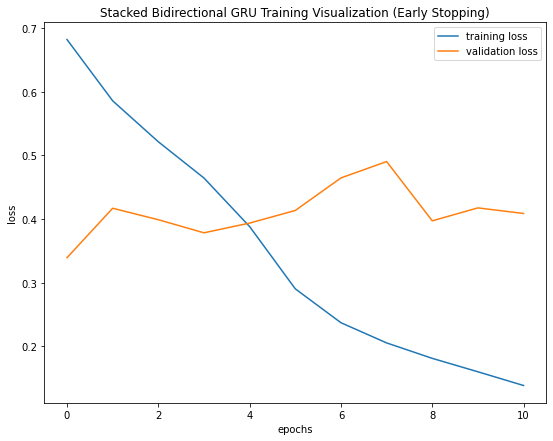

In [77]:
# Visualize LSTM training-
plt.figure(figsize = (9, 7))
plt.plot(train_history_bi_gru.history['loss'], label = 'training loss')
plt.plot(train_history_bi_gru.history['val_loss'], label = 'validation loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Stacked Bidirectional GRU Training Visualization (Early Stopping)")
plt.show()

In [78]:
# Make predictions using trained Stacked LSTM model-
y_pred_lstm = model_lstm.predict(X)

In [79]:
# Make predictions using trained Stacked Bidirectional LSTM model-
y_pred_bi_lstm = model_bi_lstm.predict(X)

In [80]:
# Make predictions using trained Stacked GRU model-
y_pred_gru = model_gru.predict(X)

In [88]:
# Make predictions using trained Stacked Bidirectional GRU model-
y_pred_bi_gru = model_bi_gru.predict(X)

In [89]:
# Sanity check-
X.shape, y.shape, y_pred_lstm.shape, y_pred_bi_lstm.shape, y_pred_gru.shape, y_pred_bi_gru.shape

((1421, 14, 7), (1421, 7), (1421, 7), (1421, 7), (1421, 7), (1421, 7))

In [90]:
# Compute metrics-
mae_lstm = mean_absolute_error(y_true = y, y_pred = y_pred_lstm)
mse_lstm = mean_squared_error(y_true = y, y_pred = y_pred_lstm)

mae_bi_lstm = mean_absolute_error(y_true = y, y_pred = y_pred_bi_lstm)
mse_bi_lstm = mean_squared_error(y_true = y, y_pred = y_pred_bi_lstm)

mae_gru = mean_absolute_error(y_true = y, y_pred = y_pred_gru)
mse_gru = mean_squared_error(y_true = y, y_pred = y_pred_gru)

mae_bi_gru = mean_absolute_error(y_true = y, y_pred = y_pred_bi_gru)
mse_bi_gru = mean_squared_error(y_true = y, y_pred = y_pred_bi_gru)

In [91]:
print(f"Stacked LSTM: MAE = {mae_lstm:.4f}, MSE = {mse_lstm:.4f} & RMSE = {np.sqrt(mse_lstm):.4f}")

Stacked LSTM: MAE = 0.5022, MSE = 0.4508 & RMSE = 0.6714


In [92]:
print(f"Stacked Bidirectional LSTM: MAE = {mae_bi_lstm:.4f}, MSE = {mse_lstm:.4f} & RMSE = {np.sqrt(mse_bi_lstm):.4f}")

Stacked Bidirectional LSTM: MAE = 0.5536, MSE = 0.4508 & RMSE = 0.7449


In [93]:
print(f"Stacked GRU: MAE = {mae_gru:.4f}, MSE = {mse_gru:.4f} & RMSE = {np.sqrt(mse_gru):.4f}")

Stacked GRU: MAE = 0.5272, MSE = 0.5087 & RMSE = 0.7133


In [94]:
print(f"Stacked Bidirectional GRU: MAE = {mae_bi_gru:.4f}, MSE = {mse_gru:.4f} & RMSE = {np.sqrt(mse_bi_gru):.4f}")

Stacked Bidirectional GRU: MAE = 0.5513, MSE = 0.5087 & RMSE = 0.7349


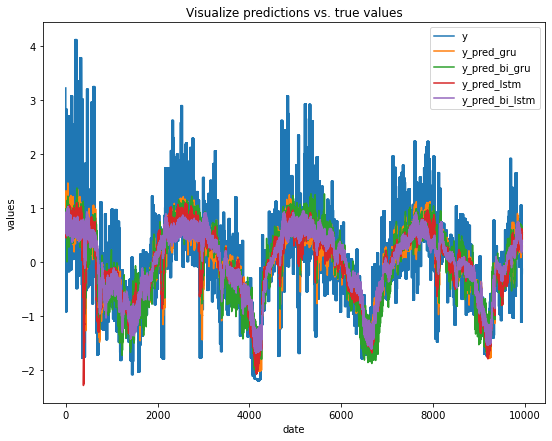

In [95]:
# Visualize predictions vs. true values-
plt.figure(figsize = (9, 7))
plt.plot(y.flatten(), label = 'y')
plt.plot(y_pred_gru.flatten(), label = 'y_pred_gru')
plt.plot(y_pred_bi_gru.flatten(), label = 'y_pred_bi_gru')
plt.plot(y_pred_lstm.flatten(), label = 'y_pred_lstm')
plt.plot(y_pred_bi_lstm.flatten(), label = 'y_pred_bi_lstm')
plt.legend(loc = 'best')
plt.title("Visualize predictions vs. true values")
plt.xlabel("date")
plt.ylabel("values")
plt.show()

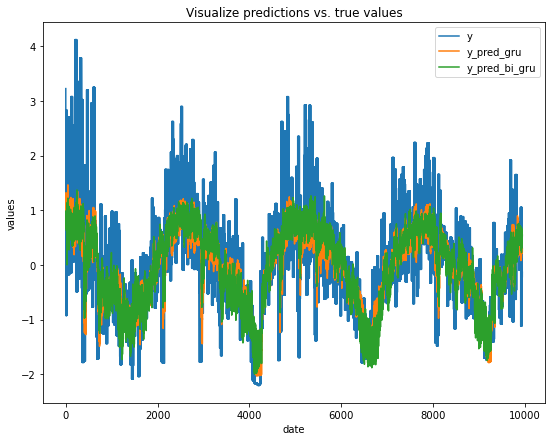

In [96]:
plt.figure(figsize = (9, 7))
plt.plot(y.flatten(), label = 'y')
plt.plot(y_pred_gru.flatten(), label = 'y_pred_gru')
plt.plot(y_pred_bi_gru.flatten(), label = 'y_pred_bi_gru')
plt.legend(loc = 'best')
plt.title("Visualize predictions vs. true values")
plt.xlabel("date")
plt.ylabel("values")
plt.show()

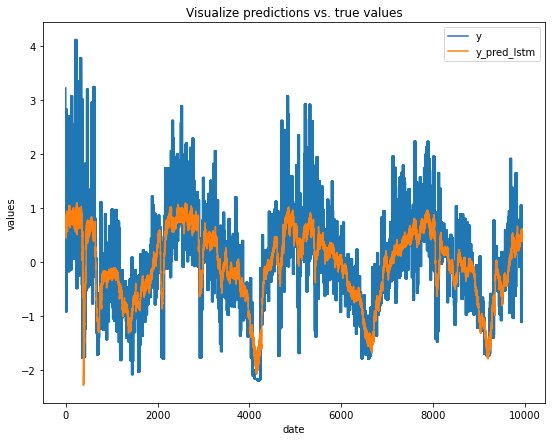

In [98]:
plt.figure(figsize = (9, 7))
plt.plot(y.flatten(), label = 'y')
plt.plot(y_pred_lstm.flatten(), label = 'y_pred_lstm')
plt.legend(loc = 'best')
plt.title("Visualize predictions vs. true values")
plt.xlabel("date")
plt.ylabel("values")
plt.show()

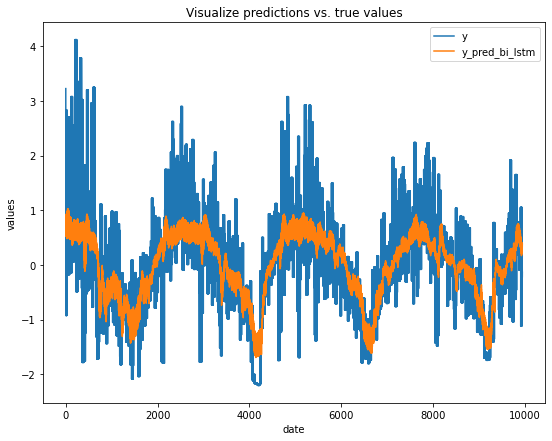

In [97]:
plt.figure(figsize = (9, 7))
plt.plot(y.flatten(), label = 'y')
plt.plot(y_pred_bi_lstm.flatten(), label = 'y_pred_bi_lstm')
plt.legend(loc = 'best')
plt.title("Visualize predictions vs. true values")
plt.xlabel("date")
plt.ylabel("values")
plt.show()

In [119]:
# Save LSTM trained model for later use-
model_lstm.save_weights("LSTM_Multivariate_household_power_consumption.h5", overwrite = True)
model_bi_lstm.save_weights("Bi-LSTM_Multivariate_household_power_consumption.h5", overwrite = True)

# Save GRU trained model for later use-
model_gru.save_weights("GRU_Multivariate_household_power_consumption.h5", overwrite = True)
model_bi_gru.save_weights("Bi-GRU_Multivariate_household_power_consumption.h5", overwrite = True)

### Make future predictions

In [99]:
# Make forecasts for the next 90 days (3 months)-
n_future = 90

In [100]:
# Extract future dates for visualization-
forecast_period_dates = pd.date_range(list(date_time_idx)[-1], periods = n_future, freq = '1d').tolist()

# From last date in 'date_time_idx' (included), include next 89 days.

In [101]:
# Get min and max dates-
forecast_period_dates[0], forecast_period_dates[-1]

(Timestamp('2010-11-26 00:00:00', freq='D'),
 Timestamp('2011-02-23 00:00:00', freq='D'))

In [102]:
# Get last date-
date_time_idx[len(date_time_idx)]

Timestamp('2010-11-26 00:00:00')

In [103]:
X[-n_future: ].shape, y[-n_future: ].shape

((90, 14, 7), (90, 7))

In [104]:
X.shape, data_scaled.shape, data.shape

((1421, 14, 7), (1441, 8), (1441, 8))

### NOTE: Reverse scaling for target 'y'

In [105]:
# Min and max of scaled target-
y.min(), y.max()

(-2.206495649781968, 4.121737842567029)

In [106]:
data.loc[:, 'Global_active_power'].min(), data.loc[:, 'Global_active_power'].max()

(250.298, 4773.386)

In [107]:
# Make predictions for the future 90 days-
future_predictions_lstm = model_lstm.predict(X[-n_future: ])

In [108]:
future_predictions_bi_lstm = model_bi_lstm.predict(X[-n_future: ])

In [109]:
# Make predictions for the future 90 days-
future_predictions_gru = model_gru.predict(X[-n_future: ])

In [110]:
future_predictions_bi_gru = model_bi_gru.predict(X[-n_future: ])

In [111]:
# Sanity check-
future_predictions_lstm.shape, future_predictions_bi_lstm.shape, future_predictions_gru.shape, future_predictions_bi_gru.shape, y[-n_future:].shape

((90, 7), (90, 7), (90, 7), (90, 7), (90, 7))

In [112]:
future_predictions_lstm[0, :]

array([-0.7941321 , -0.7466238 , -0.7264429 , -0.7620546 , -0.6431312 ,
       -0.60065097, -0.6310353 ], dtype=float32)

In [164]:
# future_predictions_lstm = std_scaler.inverse_transform(future_predictions_lstm)

In [165]:
# future_predictions_gru = std_scaler.inverse_transform(future_predictions_gru)

In [113]:
future_predictions_gru[:5, :]

array([[-0.46928123, -0.6191678 , -0.4613328 , -0.39661306, -0.44169167,
        -0.3739869 , -0.33140415],
       [-0.74401027, -0.8370646 , -0.66318786, -0.5938025 , -0.62262523,
        -0.5396868 , -0.56599927],
       [-0.9724426 , -1.0519072 , -0.83653736, -0.7722555 , -0.83171463,
        -0.6903183 , -0.7480911 ],
       [-0.9022927 , -1.0135227 , -0.8192669 , -0.7491575 , -0.8652867 ,
        -0.6923133 , -0.71428365],
       [-1.0055137 , -1.1403836 , -0.91247   , -0.86557204, -0.9671571 ,
        -0.80655473, -0.8188254 ]], dtype=float32)

In [114]:
future_predictions_gru.flatten()[:20]

array([-0.46928123, -0.6191678 , -0.4613328 , -0.39661306, -0.44169167,
       -0.3739869 , -0.33140415, -0.74401027, -0.8370646 , -0.66318786,
       -0.5938025 , -0.62262523, -0.5396868 , -0.56599927, -0.9724426 ,
       -1.0519072 , -0.83653736, -0.7722555 , -0.83171463, -0.6903183 ],
      dtype=float32)

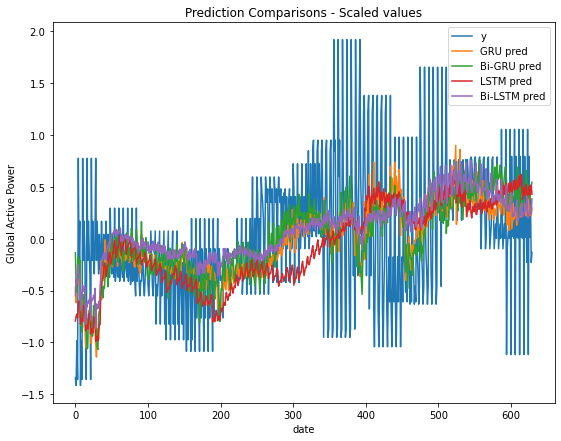

In [117]:
plt.figure(figsize = (9, 7))
plt.plot(y[-n_future: ].flatten(), label = 'y')
plt.plot(future_predictions_gru.flatten(), label = 'GRU pred')
plt.plot(future_predictions_bi_gru.flatten(), label = 'Bi-GRU pred')
plt.plot(future_predictions_lstm.flatten(), label = 'LSTM pred')
plt.plot(future_predictions_bi_lstm.flatten(), label = 'Bi-LSTM pred')
plt.xlabel("date")
plt.ylabel("Global Active Power")
plt.legend(loc = 'best')
plt.title("Prediction Comparisons - Scaled values")
plt.show()

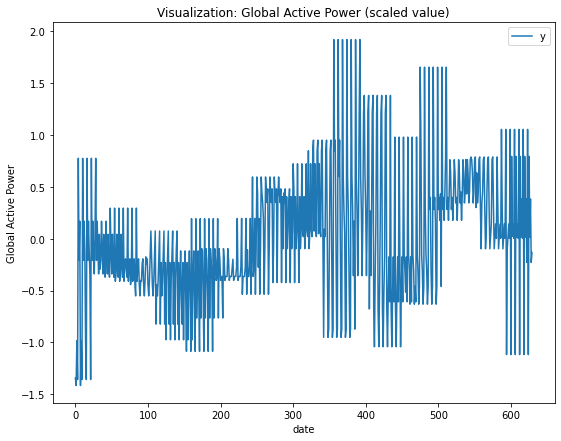

In [118]:
plt.figure(figsize = (9, 7))
plt.plot(y[-n_future: ].flatten(), label = 'y')
plt.xlabel("date")
plt.ylabel("Global Active Power")
plt.legend(loc = 'best')
plt.title("Visualization: Global Active Power (scaled value)")
plt.show()